##  Feature Analysis

    - UnivariateROC to compare feature relevance with Class
    - Dec Tree to feature rank
        + DT uses mutual information
    - Correlation Matrix
    - Normalized Mutual Information Analysis
 
     
        
## Summary

    - No features stand out as particularly relevant
    - Some show lack of relevance
    
We can compare DT ROC to NMI ROC to differentiate the procedures
     
     
## Conclusion

Perform analysis with all features

Remove the "extra" features as a test post modeling

----

### Notes and Tools

for testing class ipynbs:
    
To get FeatureRanking_AUC file working as example

     import os
     os.chdir('C:\\notebooks\\DataScienceCourse\\ipython\\')
     data = pd.read_csv('data\\ads_dataset_cut.txt', sep = '\t')
     


### Imports

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt
import seaborn as sns
import sklearn.model_selection as sk
import sklearn.metrics as m
from sklearn.tree import DecisionTreeClassifier

%store -r x
%store -r y
%store -r df 
%store -r rs

## Functions

In [36]:
def plotUnivariateROC(preds, truth, label_string):
    '''
    preds is an nx1 array of predictions
    truth is an nx1 array of truth labels
    label_string is text to go into the plotting label
    '''

    #1. call the roc_curve function to get the ROC X and Y values
    fpr, tpr, thresholds = m.roc_curve(truth, preds)
    
    #2. Input fpr and tpr into the auc function to get the AUC
    roc_auc = m.auc(fpr, tpr)
    
    #we are doing this as a special case because we are sending unfitted predictions
    #into the function
    if roc_auc < 0.5:
        fpr, tpr, thresholds = m.roc_curve(truth, -1 * preds)
        roc_auc = m.auc(fpr, tpr)

    #chooses a random color for plotting
    c = (np.random.rand(), np.random.rand(), np.random.rand())

    #create a plot and set some options
    plt.plot(fpr, tpr, color = c, label = label_string + ' (AUC = %0.3f)' % roc_auc)
    

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc="lower right")
    
    return roc_auc

def plotCorr(dat, lab, h, w):
    '''
    Do a heatmap to visualize the correlation matrix, dropping the label
    '''

    dat = dat.drop(lab, 1)
    #Get correlation and 0 out the diagonal (for plotting purposes)
    c_dat = dat.corr()
    for i in range(c_dat.shape[0]):
        c_dat.iloc[i,i] = 0

    c_mat = c_dat.value
    #c_mat = c_mat[:-1, :-1]
    fig, ax = plt.subplots()
    heatmap = plt.pcolor(c_mat, cmap = plt.cm.RdBu)

    #Set the tick labels and center them
    ax.set_xticks(np.arange(c_dat.shape[0]) + 0.5, minor = False)
    ax.set_yticks(np.arange(c_dat.shape[1]) + 0.5, minor = False)
    ax.set_xticklabels(c_dat.index.values, minor = False, rotation = 45)
    ax.set_yticklabels(c_dat.index.values, minor = False)
    heatmap.axes.set_ylim(0, len(c_dat.index))  
    heatmap.axes.set_xlim(0, len(c_dat.index)) 
    plt.colorbar(heatmap, ax = ax)

    #plt.figure(figsize = (h, w))
    fig = plt.gcf()
    fig.set_size_inches(h, w)


# ----- Used on Decision Tree for Mutual Information ----
def plotMI(dat, lab, width = 0.35):
    '''
    Draw a bar chart of the normalized MI between each X and Y
    '''
    X = dat.drop(lab, 1)
    Y = dat[[lab]].values
    cols = X.columns.values
    mis = []

    #Start by getting MI
    for c in cols:
        mis.append(m.normalized_mutual_info_score(Y.ravel(), X[[c]].values.ravel()))

    #Get signs by correlation
    corrs = dat.corr()[lab]
    corrs[corrs.index != lab]
    df = pd.DataFrame(list(zip(mis, cols)), columns = ['MI', 'Lab'])
    df = pd.concat([df, pd.DataFrame(list(corrs), columns = ['corr'])], axis=1).reindex()
    makeBarSigned(df, 'MI', 'Lab', width)
        
        
def makeBarSigned(df, h, lab,  width):
    '''
    Contains
    '''
    df_s = df.sort_values(by = [h], ascending = False)

    #Get a barplot
    ind = np.arange(df_s.shape[0])
    labs = df_s[[lab]].values.ravel()
    h_pos = (df_s[['corr']].values.ravel() > 0) * df_s.MI
    h_neg = (df_s[['corr']].values.ravel() < 0) * df_s.MI

    fig = plt.figure(facecolor = 'w', figsize = (12, 6))
    ax = plt.subplot(111)
    plt.subplots_adjust(bottom = 0.25)

    rec = ax.bar(ind + width, h_pos, width, color='r', label = 'Positive')
    rec = ax.bar(ind + width, h_neg, width, color='b', label = 'Negative')

    ax.set_xticks(np.arange(10))
    ax.set_xticklabels(labs, rotation = 45, size = 14)

    plt.legend()
    
    

## Univariate Analysis

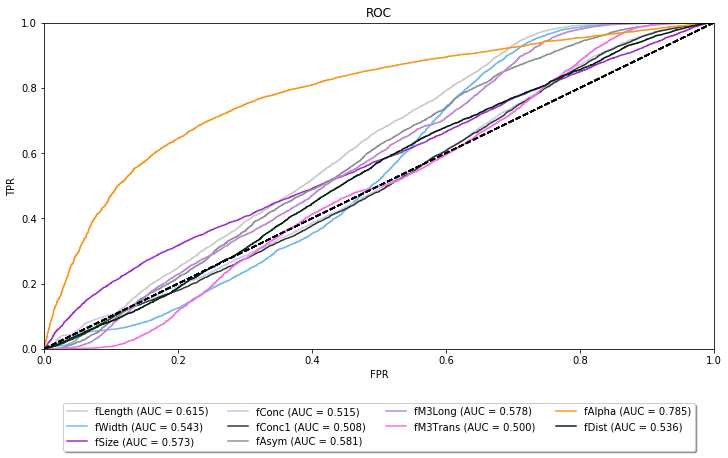

In [37]:
fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)

#Plot the univariate AUC on the training data. Store the AUC


feature_auc_dict = {}
for col in df.drop('Class',1).columns:
    feature_auc_dict[col] = plotUnivariateROC(x[col], y, col)


# Put a legend below current axis
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.0 , box.width, box.height * 1])
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
              shadow = True, ncol = 4, prop = {'size':10})

Index(['auc', 'mi'], dtype='object')

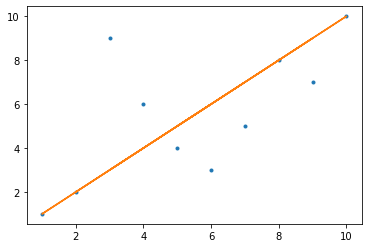

In [51]:
#Add auc and mi each to a single dataframe
df_auc = pd.DataFrame(pd.Series(feature_auc_dict), columns = ['auc'])
df_mi = pd.DataFrame(pd.Series(feature_mi_dict), columns = ['mi'])

#Now merge the two on the feature name
feat_imp_df = df_auc.merge(df_mi, left_index = True, right_index = True)
feat_imp_df

#Now create a df that holds the ranks of auc and mi 
feat_ranks = feat_imp_df.rank(axis = 0, ascending = False)

#Plot the two ranks
plt.plot(feat_ranks.auc, feat_ranks.mi, '.')
#Plot a y=x reference line
plt.plot(feat_ranks.auc, feat_ranks.auc,)

feat_ranks.columns

Do the feature importance metrics above completely agree with each other (in terms of rank order)? If not, why do you suppose?


Some discussion points:
- A feature can be incredibly predictive but has low coverage. I.e., look at 'multiple_buy.' When it is positive it is highly predictive, but it is only positive in a few cases. This will make the AUC lower (because it is the area under the curve).
- The Mutual Information as represented by the feature_importance\_ attribute of the Decision Tree is technically not Mutual Information between X and Y. Technically, it is the cumulative MI of possible multiple binary splits on the given feature throughout the tree. The [source code](https://github.com/scikit-learn/scikit-learn/blob/a24c8b464d094d2c468a16ea9f8bf8d42d949f84/sklearn/tree/_tree.pyx#L1056-L1092) can show you how this is done. Further, this the cumulative MI within the tree, which is conditional on any prior splits. When two (or more) variables are correlated, the information gained from a redundant feature is often very low. Thus, you can see that a feature might have a high AUC but low MI as computed by the DT learning process.
- The right way to do this analysis would be to compute only univariate MI between each X and Y separately (the way we did it for AUC).

## Pairplot

In [38]:
## Review what it is showing

#sns.pairplot(df, palette='bright') 

## Correlation Matrix

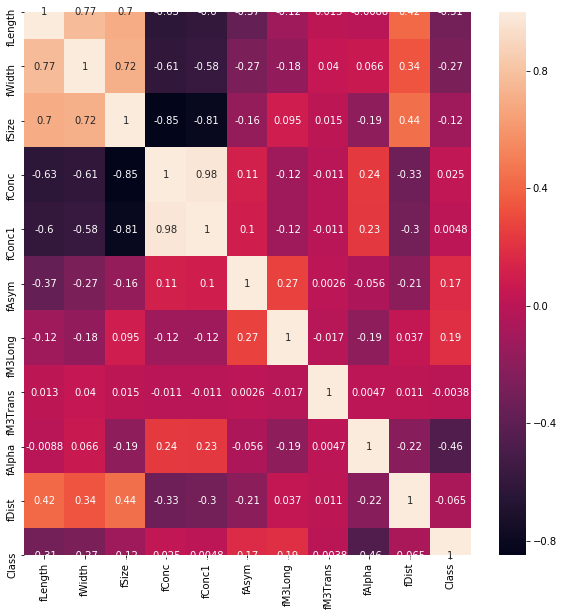

In [39]:
fig, ax = plt.subplots(figsize=(10,10))     
sns.heatmap(df.corr(), annot=True)

## Decision Tree for Mutual Information

In [40]:
#DT for feature importance

dt = DecisionTreeClassifier(criterion = 'entropy')
dt.fit(x, y)
feature_mi = dt.feature_importances_
feature_mi_dict = dict(zip(x.columns.values, feature_mi))

Text(0.5, 1.0, 'Mutual Information Between Feature and Class')

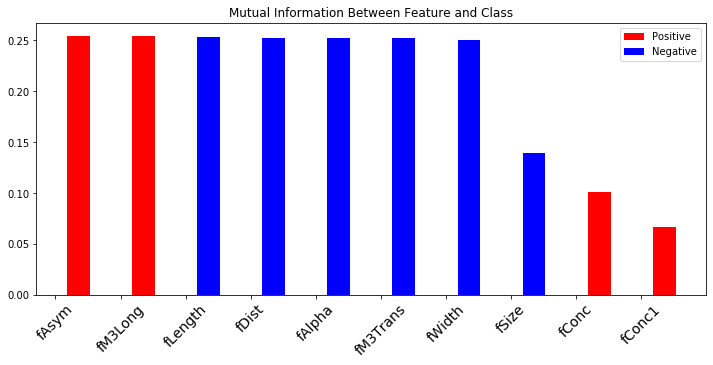

In [41]:
import warnings
warnings.filterwarnings('ignore')

plotMI(df, 'Class')
plt.title('Mutual Information Between Feature and Class')

## Feature Analysis on New Datasets

In [42]:
%store -r fe_df
%store -r up_df

### M^F

In [43]:
## Review what it is showing

#sns.pairplot(fe_df, palette='bright') 